### Sign Recognition via ResNet

#### Import Modules

In [2]:
# IMPORT MODULES
# Import Numpy, TensorFlow, Scipy, Keras
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

# Print
print("Import Modules")

Import Modules


#### Model Architecture

In [3]:
# IDENTITY BLOCK
# Define Identity Block
def IdentityBlock(X,F,Filters,Stage,Block):    
    # Defining Name Basis
    ConvNameBase='Res'+str(Stage)+Block+'_Branch'
    BnNameBase='Bn'+str(Stage)+Block+'_Branch'
    
    # Retrieve Filters
    F1,F2,F3=Filters
    
    # Save the Input Value 
    XShortcut=X
    
    # First Component of Main Path
    X=Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid',name=ConvNameBase+'2a',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2a')(X)
    X=Activation('relu')(X)

    # Second Component of Main Path
    X=Conv2D(filters=F2,kernel_size=(F,F),strides=(1,1),padding='same',name=ConvNameBase+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2b')(X)
    X=Activation('relu')(X)

    # Third component of Main Path
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=ConvNameBase+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2c')(X)

    # Add Shortcut Value to Main Path, and Pass it through a RELU Activation
    X=Add()([X,XShortcut])
    X=Activation('relu')(X)
    
    # Return    
    return X

In [4]:
# CONVOLUTIONAL BLOCK
# Define Convolutional Block

def ConvolutionalBlock(X,F,Filters,Stage,Block,S=2):    
    # Defining Name Basis
    ConvNameBase='Res'+str(Stage)+Block+'_Branch'
    BnNameBase='Bn'+str(Stage)+Block+'_Branch'
    
    # Retrieve Filters
    F1,F2,F3=Filters
    
    # Save the Input Value 
    XShortcut=X

    # First Component of Main Path 
    X=Conv2D(F1,(1,1),strides=(S,S),name=ConvNameBase+'2a',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2a')(X)
    X= Activation('relu')(X)
    
    # Second Component of Main Path
    X=Conv2D(F2,(F,F),strides=(1,1),padding='same',name=ConvNameBase+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2b')(X)
    X=Activation('relu')(X)

    # Third component of Main Path
    X=Conv2D(F3,(1,1),strides=(1,1),name=ConvNameBase+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=BnNameBase+'2c')(X)

    # Shortcut Path
    XShortcut=Conv2D(F3,(1,1),strides=(S,S),name =ConvNameBase+'1',kernel_initializer=glorot_uniform(seed=0))(XShortcut)
    XShortcut=BatchNormalization(axis=3,name=BnNameBase+'1')(XShortcut)
  
    # Add Shortcut Value to Main Path, and Pass it through a RELU Activation
    X=Add()([X,XShortcut])
    X=Activation('relu')(X)
    
    # Return
    return X

In [5]:
# RESNET50 MODEL
# Define ResNet50 Model

def ResNet50(InputShape=(64,64,3),Classes=6):    
    # Define the Input as a Tensor
    XInput=Input(InputShape)
    
    # Zero-Padding
    X=ZeroPadding2D((3,3))(XInput)
    
    # Stage 1
    X=Conv2D(64,(7,7),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name='bn_conv1')(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((3,3),strides=(2,2))(X)

    # Stage 2
    X=ConvolutionalBlock(X,F=3,Filters=[64,64,256],Stage=2,Block='a',S=1)
    X=IdentityBlock(X,3,[64,64,256],Stage=2,Block='b')
    X=IdentityBlock(X,3,[64,64,256],Stage=2,Block='c')

    # Stage 3 
    X=ConvolutionalBlock(X,F=3,Filters=[128,128,512],Stage=3,Block='a',S=2)
    X=IdentityBlock(X,3,[128,128,512],Stage=3,Block='b')
    X=IdentityBlock(X,3,[128,128,512],Stage=3,Block='c')
    X=IdentityBlock(X,3,[128,128,512],Stage=3,Block='d')

    # Stage 4 (≈6 lines)
    X=ConvolutionalBlock(X, F = 3, Filters = [256, 256, 1024], Stage = 4, Block='a', S = 2)
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='b')
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='c')
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='d')
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='e')
    X=IdentityBlock(X,3,[256,256,1024],Stage=4,Block='f')

    # Stage 5 (≈3 lines)
    X=ConvolutionalBlock(X,F=3,Filters=[512,512,2048],Stage=5,Block='a',S=2)
    X=IdentityBlock(X,3,[512,512,2048],Stage=5,Block='b')
    X=IdentityBlock(X,3,[512,512,2048],Stage=5,Block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X=AveragePooling2D(pool_size=(2,2),name='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X=Flatten()(X)
    X=Dense(Classes,activation='softmax',name='fc'+str(Classes),kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    ResNetModel=Model(inputs=XInput,outputs=X,name='ResNet50')

    return ResNetModel

In [6]:
Model=ResNet50(InputShape=(64,64,3),Classes=6)

In [8]:
Model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

The model is now ready to be trained. The only thing you need is a dataset.

Let's load the SIGNS Dataset.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 6** </u><font color='purple'>  : **SIGNS dataset** </center></caption>


#### Load Data

In [9]:
XTrainOrig,YTrainOrig,XTestOrig,YTestOrig,Classes=load_dataset()

# Normalize image vectors
XTrain=XTrainOrig/255.
XTest=XTestOrig/255.

# Convert training and test labels to one hot matrices
YTrain=convert_to_one_hot(YTrainOrig,6).T
YTest=convert_to_one_hot(YTestOrig,6).T

print("Number of Training Examples = "+str(XTrain.shape[0]))
print("Number of Test Examples = "+str(XTest.shape[0]))
print("XTrain Shape: "+str(XTrain.shape))
print("YTrain Shape: "+str(YTrain.shape))
print("XTest Shape: "+str(XTest.shape))
print("YTest Shape: "+str(YTest.shape))

Number of Training Examples = 1080
Number of Test Examples = 120
XTrain Shape: (1080, 64, 64, 3)
YTrain Shape: (1080, 6)
XTest Shape: (120, 64, 64, 3)
YTest Shape: (120, 6)


#### Training

In [11]:
Model.fit(XTrain,YTrain,epochs=2,batch_size=32)

Epoch 1/2
1080/1080 [==============================] - 258s - loss: 1.8622 - acc: 0.5250   
Epoch 2/2
1080/1080 [==============================] - 237s - loss: 0.5908 - acc: 0.8102   


#### Evaluation

In [12]:
Preds=Model.evaluate(XTest,YTest)
print("Loss= "+str(Preds[0]))
print("Test Accuracy= "+str(Preds[1]))

120/120 [==============================] - 7s     
Loss= 0.421104447047
Test Accuracy= 0.841666662693


In [13]:
OrigModel=load_model('ResNet50.h5') 

In [14]:
Preds=OrigModel.evaluate(XTest,YTest)
print("Loss = "+str(Preds[0]))
print("Test Accuracy = "+str(Preds[1]))

120/120 [==============================] - 8s     
Loss = 0.255690792203
Test Accuracy = 0.91666667064


Input Image Shape: (1, 64, 64, 3)
Class Prediction Vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[  1.46631777e-01   3.87719716e-03   8.47503722e-01   9.83841746e-05
    5.38978667e-04   1.34998769e-03]]


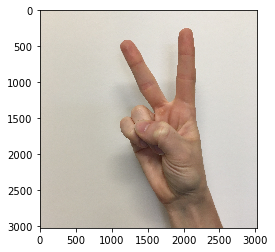

In [16]:
ImgPath='images/my_image.jpg'
Img=image.load_img(ImgPath,target_size=(64,64))
X=image.img_to_array(Img)
X=np.expand_dims(X,axis=0)
X=preprocess_input(X)
print('Input Image Shape:',X.shape)
MyImage=scipy.misc.imread(ImgPath)
imshow(MyImage)
print("Class Prediction Vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(OrigModel.predict(X))

You can also print a summary of your model by running the following code.

In [17]:
Model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 70, 70, 3)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 64)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 32, 32, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

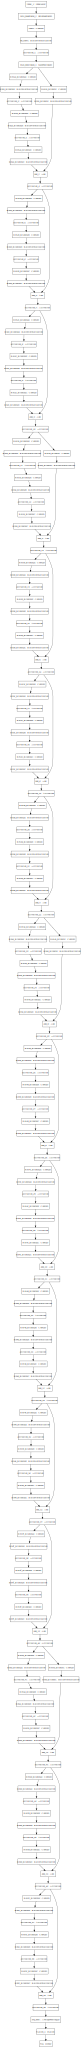

In [18]:
plot_model(Model,to_file='model.png')
SVG(model_to_dot(Model).create(prog='dot',format='svg'))